##Setup


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd /content/gdrive/MyDrive/NeRF

In [ ]:
!pip install dm-haiku optax imageio-ffmpeg
import sys
import os
import imageio
from load_llff_data import load_llff_data
import haiku as hk
import jax
import optax
import jax.numpy as jnp
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [ ]:
## SOURCE: https://github.com/deepmind/dm-haiku/issues/18#issuecomment-981814403
def save(ckpt_dir: str, state) -> None:
 with open(os.path.join(ckpt_dir, "arrays.npy"), "wb") as f:
   for x in jax.tree_util.tree_leaves(state):
     np.save(f, x, allow_pickle=False)

 tree_struct = jax.tree_map(lambda t: 0, state)
 with open(os.path.join(ckpt_dir, "tree.pkl"), "wb") as f:
   pickle.dump(tree_struct, f)

def restore(ckpt_dir):
 with open(os.path.join(ckpt_dir, "tree.pkl"), "rb") as f:
   tree_struct = pickle.load(f)
 
 leaves, treedef = jax.tree_util.tree_flatten(tree_struct)
 with open(os.path.join(ckpt_dir, "arrays.npy"), "rb") as f:
   flat_state = [np.load(f) for _ in leaves]

 return jax.tree_util.tree_unflatten(treedef, flat_state)
 ###############################################################################

##Data loading

In [ ]:
# Note: If you want to use custom data, this code will only work for forward-facing data similar to the llff data.
#       Additionally, you will have to use software (like COLMAP) to get camera information.
datadir = "./nerf_llff_data/room" # options: fern, flower, fortress, horns, leaves, orchids, room, trex
factor = 32 # The paper uses factor=4, but I used factor=32 for faster convergence (factor=32 means the height and width of the images are 1/32 compared to those of the original images)
spherify = False # llff data are forward-facing, not spherical
llffhold = 16 # 1/llffhold images are kept for the test set

In [ ]:
####### CODE SLIGHTLY MODIFIED FROM https://github.com/bmild/nerf/blob/master/run_nerf_helpers.py
def get_rays_np(H, W, focal, c2w):
    """Get ray origins, directions from a pinhole camera."""
    i, j = jnp.meshgrid(jnp.arange(W, dtype=jnp.float32),
                       jnp.arange(H, dtype=jnp.float32), indexing='xy')
    dirs = jnp.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -jnp.ones_like(i)], -1)
    rays_d = jnp.sum(dirs[..., jnp.newaxis, :] * c2w[:3, :3], -1)
    rays_o = c2w[:3, -1]
    return rays_o, rays_d

def ndc_rays(H, W, focal, near, rays_o, rays_d):
    """Normalized device coordinate rays.
    Space such that the canvas is a cube with sides [-1, 1] in each axis.
    Args:
      H: int. Height in pixels.
      W: int. Width in pixels.
      focal: float. Focal length of pinhole camera.
      near: float or array of shape[batch_size]. Near depth bound for the scene.
      rays_o: array of shape [batch_size, 3]. Camera origin.
      rays_d: array of shape [batch_size, 3]. Ray direction.
    Returns:
      rays_o: array of shape [batch_size, 3]. Camera origin in NDC.
      rays_d: array of shape [batch_size, 3]. Ray direction in NDC.
    """
    # Shift ray origins to near plane
    t = -(near + rays_o[..., 2]) / rays_d[..., 2]
    rays_o = rays_o + t[..., None] * rays_d

    # Projection
    o0 = -1./(W/(2.*focal)) * rays_o[..., 0] / rays_o[..., 2]
    o1 = -1./(H/(2.*focal)) * rays_o[..., 1] / rays_o[..., 2]
    o2 = 1. + 2. * near / rays_o[..., 2]

    d0 = -1./(W/(2.*focal)) * \
        (rays_d[..., 0]/rays_d[..., 2] - rays_o[..., 0]/rays_o[..., 2])
    d1 = -1./(H/(2.*focal)) * \
        (rays_d[..., 1]/rays_d[..., 2] - rays_o[..., 1]/rays_o[..., 2])
    d2 = -2. * near / rays_o[..., 2]

    rays_o = jnp.stack([o0, o1, o2], -1)
    rays_d = jnp.stack([d0, d1, d2], -1)

    return rays_o, rays_d
##################################################################################################

In [ ]:
# for loading images + setting up train dataset
images, poses, bds, render_poses, test_indices = load_llff_data(datadir, factor, recenter=True, bd_factor=.75, spherify=spherify)
hwf = poses[0, :3, -1]
poses = poses[:, :3, :4]
num_images = images.shape[0]
test_indices = [int(i) for i in jnp.arange(num_images)[::llffhold]]
train_indices = list(set(range(num_images)) - set(test_indices))
height, width, focal_length = hwf

all_rays = [get_rays_np(height, width, focal_length, poses[i]) for i in train_indices]
origins = [entry[0] for entry in all_rays]
directions = [entry[1] for entry in all_rays]
origins = jnp.stack(origins, axis=0)
directions = jnp.stack(directions, axis=0)

images = jnp.transpose(images, (0,2,1,3))
test_images = images[jnp.array(test_indices)]
train_images = images[jnp.array(train_indices)]
test_bds = bds[test_indices]
train_bds = bds[train_indices]
directions = jnp.transpose(directions, (0,2,1,3))

near = 0
far = 1

Loaded image data (756, 1008, 3, 41) [ 756.         1008.          767.65956772]
Loaded ./nerf_llff_data/room 10.706691140704915 91.66782174279389
recentered (3, 5)
[[ 1.0000000e+00 -3.2399280e-10 -7.2935608e-10  7.9957454e-09]
 [ 3.2399280e-10  1.0000000e+00  9.5727992e-10 -1.4537718e-09]
 [ 7.2935608e-10 -9.5727992e-10  1.0000000e+00  2.3169489e-09]]
Data:
(41, 3, 5) (41, 756, 1008, 3) (41, 2)
HOLDOUT view is 35


In [ ]:
# for setting up test dataset
test_all_rays = [get_rays_np(height, width, focal_length, poses[i]) for i in test_indices]
test_origins = [entry[0] for entry in all_rays]
test_directions = [entry[1] for entry in all_rays]
test_origins = jnp.stack(test_origins, axis=0)
test_directions = jnp.stack(test_directions, axis=0)
test_images = images[jnp.array(test_indices)]
test_directions = jnp.transpose(test_directions, (0,2,1,3))

##Batching + Sampling

In [ ]:
def batch_rays(H, W, origins, directions, train_images, bds, num_rays=4096):
  img_indices = np.random.randint(0, high=directions.shape[0]-1, size=num_rays)
  height_indices = np.random.randint(0, high=H-1, size=num_rays)
  width_indices = np.random.randint(0, high=W-1, size=num_rays)

  origins = origins[img_indices]
  directions = directions[img_indices[:], width_indices[:], height_indices[:]]
  real_pixels = train_images[img_indices[:], width_indices[:], height_indices[:]]

  near = bds[img_indices, 0]
  return origins, directions, real_pixels, near

In [ ]:
def coarse_sampling(near, far, origins, directions, num_samples=64, random_spacing=True):
  vals = jnp.linspace(start=0, stop=1, num=num_samples)
  vals = near * (1-vals) + far * (vals)

  if random_spacing:
    mids = .5 * (vals[1:] + vals[:-1])
    upper = jnp.concatenate([mids, vals[-1:]], -1)
    lower = jnp.concatenate([vals[:1], mids], -1)
    t_rand = np.random.uniform(size=vals.shape)
    vals = lower + (upper - lower) * t_rand

  points = directions[:,None,:] * vals[None,:,None] + origins[:,None,:]
  return points, vals

In [ ]:
def fine_sampling(vals, weights, num_samples = 128):
  lower = vals[:-1]
  upper = vals[1:]
  mid = 0.5 * (lower + upper)
  vals = jnp.concatenate([vals[:1], mid, vals[-1:]], axis=-1)

  weights = weights.at[:,0].divide(2)
  weights = weights.at[:,-1].divide(2)
  weights += 1e-7
  pdf = weights / weights.sum(axis=-1)[:,None]
  cdf = jnp.cumsum(pdf, axis=-1)

  u = np.random.uniform(low=0.0, high=1.0, size=num_samples)

  scaling_vec = jnp.arange(cdf.shape[0]) * 2
  indices = np.searchsorted((cdf + scaling_vec[:,None]).ravel(), (u[:,None] + scaling_vec[None,:]).ravel().sort(), side="left") % cdf.shape[-1]

  indexing_helper = jnp.repeat(jnp.arange(cdf.shape[0]), num_samples)
  cdf = jnp.concatenate([jnp.zeros([cdf.shape[0],1]), cdf], axis=-1)
  weight_diffs = (cdf[indexing_helper, indices+1] - cdf[indexing_helper, indices]).reshape([-1, num_samples])

  u.sort()
  new_vals = (u[None,:] - cdf[indexing_helper,indices].reshape((-1, num_samples))) / weight_diffs
  new_vals = jnp.reshape(vals[indices], (-1, num_samples)) + jnp.reshape(vals[indices+1] - vals[indices], (-1, num_samples)) * new_vals
  return new_vals

##Deep Learning

In [ ]:
def positional_embedding(input, L: int):
  helper = jnp.repeat(jnp.arange(L), 2)
  helper = (2 ** helper * jnp.pi)[None,:,None,None] * input[:,None,:,:]
  helper = jnp.transpose(helper, (0,2,3,1))
  helper = jnp.reshape(helper, list(helper.shape[:-2]) + [-1])
  helper = helper.at[:,:,::2].set(jnp.sin(helper[:,:,::2]))
  helper = helper.at[:,:,1::2].set(jnp.cos(helper[:,:,1::2]))
  return helper

In [ ]:
def volume_rendering(colors, densities, vals, ray_directions):
  # I set the last distance to 0 but the code for the paper sets it to infinity
  dists = jnp.concatenate([vals[:,1:] - vals[:,:-1], jnp.broadcast_to(0, (vals.shape[0], 1))], axis=-1)
  dists = dists * jnp.linalg.norm(ray_directions, axis=-1)[:,None]
  weights = 1 - jnp.exp(-densities * dists[:,:,None])
  T_vals = dists
  T_vals = densities * T_vals[:,:,None]
  # I believe the original code for the paper uses cumprod after exp instead of cumsum before exp for numeric stability as the densities are unbounded
  T_vals = jnp.exp(-T_vals)
  T_vals = T_vals.at[:,1:,:].set(T_vals[:,:-1,:])
  T_vals = T_vals.at[:,0,:].set(1)
  T_vals = jnp.cumprod(T_vals, axis=1)
  weights = weights * T_vals
  
  final_colors = weights * colors
  final_colors = jnp.sum(final_colors, axis=1)
  return final_colors, weights[:,:,0]

In [ ]:
# These are just linear layers followed by their corresponding non-linear activation functions
class LinearReluBlock(hk.Module):
  def __init__(self, num_features, name=None):
    super(LinearReluBlock, self).__init__(name=name)
    self.linear_layer = hk.Linear(num_features)

  def __call__(self, x):
    return jax.nn.relu(self.linear_layer(x))

class ColorBlock(hk.Module):
  def __init__(self, name=None):
    super(ColorBlock, self).__init__(name=name)
    self.linear_layer = hk.Linear(3)

  def __call__(self, x):
    return jax.nn.sigmoid(self.linear_layer(x))

In [ ]:
def NeRF(batch_origins, batch_directions, near, far, real_pixels):
  # These are all the layers used in the model
  mlp_1 = hk.Sequential([LinearReluBlock(num_features) for _ in range(5)])
  mlp_2 = hk.Sequential([LinearReluBlock(num_features) for _ in range(3)])
  linear_to_density = hk.Linear(1)
  linear_to_linear = hk.Linear(num_features)
  linear_downsample = LinearReluBlock(num_features//2)
  linear_to_color = ColorBlock()

  def calculate_color_and_density(points, directions):
    points = positional_embedding(points, L=10)
    directions = positional_embedding(directions, L=4)

    curr = mlp_1(points)
    curr = jnp.concatenate([points, curr], axis=-1)
    curr = mlp_2(curr)
    curr = linear_to_linear(curr)
    vol_density = jax.nn.relu(linear_to_density(curr))
    curr = jnp.concatenate([curr, directions], axis=-1)
    curr = linear_downsample(curr)
    color = linear_to_color(curr)

    return color, vol_density

  points, vals = coarse_sampling(near, far, batch_origins, batch_directions)
  directions = jnp.broadcast_to(batch_directions[:,None,:], (points.shape[0], points.shape[1], 3))
  directions = directions / jnp.linalg.norm(directions, axis=-1)[:,:,None]
  coarse_color, coarse_vol_density = calculate_color_and_density(points, directions)
  coarse_pixels, coarse_weights = volume_rendering(coarse_color, coarse_vol_density, jnp.broadcast_to(vals, (points.shape[0], vals.shape[0])), batch_directions)
  
  new_vals = fine_sampling(vals, coarse_weights)
  new_points = batch_directions[:,None,:] * new_vals[:,:,None] + batch_origins[:,None,:]
  directions = jnp.broadcast_to(batch_directions[:,None,:], (new_points.shape[0], new_points.shape[1], 3))
  directions = directions / jnp.linalg.norm(directions, axis=-1)[:,:,None]
  fine_color, fine_vol_density = calculate_color_and_density(new_points, directions)

  final_vals = jnp.concatenate([jnp.broadcast_to(vals, (points.shape[0], vals.shape[0])), new_vals], axis=1)
  final_colors = jnp.concatenate([coarse_color, fine_color], axis=1)
  final_densities = jnp.concatenate([coarse_vol_density, fine_vol_density], axis=1)
  sorted_indices = jnp.argsort(final_vals)

  final_vals = jnp.take_along_axis(final_vals, sorted_indices, axis=1)
  final_colors = jnp.take_along_axis(final_colors, sorted_indices[:,:,None], axis=1)
  final_densities = jnp.take_along_axis(final_densities, sorted_indices[:,:,None], axis=1)
  fine_pixels, _ = volume_rendering(final_colors, final_densities, final_vals, batch_directions)

  coarse_loss = jnp.sum(jnp.square(coarse_pixels - real_pixels)) / batch_origins.shape[0]
  fine_loss = jnp.sum(jnp.square(fine_pixels - real_pixels)) / batch_origins.shape[0]
  loss = coarse_loss + fine_loss
  return {"loss": loss, "pixels": fine_pixels, "coarse_loss": coarse_loss, "fine_loss":  fine_loss}

##Training

In [ ]:
train_iters = 150000 # the paper uses 100k-300k steps, but colab will likely kick you out after around 65k
num_rays = 1024 # 4096 crashes on colab but that is what the paper uses
start_learning_rate = 2e-4 # 5e-4 was used in the paper originally, but it seems too high for this implementation
num_features = 256
rng = jax.random.PRNGKey(42)

In [ ]:
scheduler = optax.exponential_decay(
    init_value=start_learning_rate, 
    transition_steps=train_iters,
    decay_rate=10**-(1/train_iters)) # divides learning rate by 10 during training

optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.scale_by_adam(),
    optax.scale_by_schedule(scheduler),
    optax.scale(-1.0)
)

In [ ]:
# for initialization of new model
dummy_origins, dummy_directions, real_pixels, near_pre_normalization = batch_rays(height, width, origins, directions, train_images, train_bds, num_rays=1)
dummy_origins, dummy_directions = ndc_rays(height, width, focal_length, 1, dummy_origins, dummy_directions)
NeRF = hk.transform_with_state(NeRF)
params, state = NeRF.init(rng, dummy_origins, dummy_directions, near, far, real_pixels)
opt_state = optimizer.init(params)

In [ ]:
# for restoring a saved model
#NeRF = hk.transform_with_state(NeRF)
#params = restore(datadir + "/params")
#state = restore(datadir + "/states")
#with open(datadir + "/opt_states/opt_state.pkl", "rb") as input_file:
#  opt_state = pickle.load(input_file)

In [ ]:
@jax.jit
def train_step(params, state, opt_state, batch_origins, batch_directions, near, far, real_pixels):
  def adapt_forward(params, state, batch_origins, batch_directions, near, far, real_pixels):
    model_output, state = NeRF.apply(params, state, None, batch_origins, batch_directions, near, far, real_pixels)
    loss = model_output["loss"]
    return loss, (model_output, state)

  grads, (model_output, state) = (jax.grad(adapt_forward, has_aux=True)(params, state, batch_origins, batch_directions, near, far, real_pixels))

  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return params, state, opt_state, model_output

0.2448772392719984
0.10536839881539345
0.09210117791593075
0.08725763511657715
0.08537037897109985
0.08020000694692135
0.07637247806787491
0.07165956135839224
0.06944093052297831
0.06450366017222404
saved!
0.06551405863463879
0.060902183778584
0.05738425458967686
0.05450523536652327
0.0504012778326869
0.04867880596220493
0.06381230834126472
0.04684925040602684
0.043975087128579615
0.040449881076812744
saved!


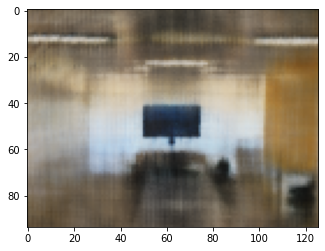

0.03757952637597919
0.036139857035130264
0.037120959635823965
0.033484567292034625
0.03188749439269304
0.029828528560698033
0.029028261348605155
0.028484284579753875
0.027245094384998083
0.028383684888482093
saved!
0.024959323950111866
0.02430030456185341
0.023040145244449375
0.022333436105400326
0.0216121258251369
0.02077271693199873
0.02011315086297691
0.019335053443908692
0.018749814860522747
0.01805081761069596
saved!


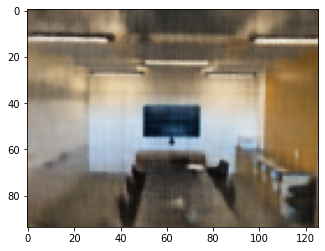

0.01739152989163995
0.01697150012664497
0.01644892135448754
0.015912803921848535
0.015622351706027984
0.015133622758090496
0.014555110631510616
0.014720981689170003
0.014142447762191295
0.014117923397570849
saved!
0.013368510130792856
0.013469841547310353
0.012955340594053268
0.012095893505960702
0.01172423693537712
0.011548831522464753
0.011660345373675227
0.011455294260755181
0.011214305030182004
0.011154682207852602
saved!


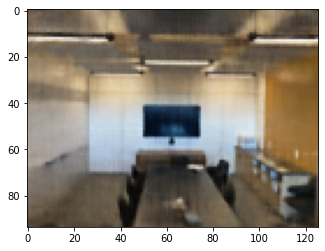

0.01082322633266449
0.010716642677783966
0.011008666409179569
0.00999042487796396
0.01134460826870054
0.010459019693545997
0.0095816497085616
0.009394212714396418
0.009115079154260457
0.009112148908898235
saved!
0.009052924815565348
0.00869904183037579
0.008329817934893072
0.008257118666544556
0.008280003486201167
0.007968207336962223
0.008228253117762506
0.007847129017114639
0.007548929966054857
0.007480088385753334
saved!


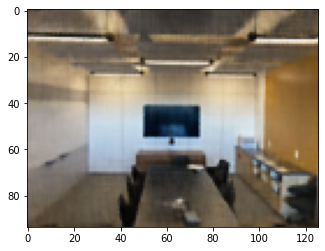

0.007444854114204645
0.007303587961941958
0.0071083494881168
0.007119371847249568
0.006774159261956811
0.006882676005363465
0.006612179330550134
0.006693992889486253
0.007231850637122989
0.006406170360744
saved!
0.006109362993389368
0.006000521009787917
0.005809403267689049
0.005888738352805376
0.005922529523726553
0.0057007874418050055
0.005595321571454406
0.005499736418016255
0.005788943848572672
0.005561531614512205
saved!


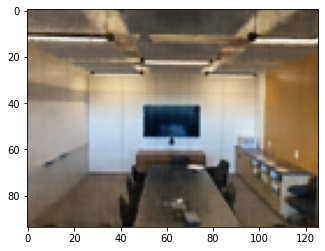

0.005484622155316174
0.005452658726833761
0.005287920983042568
0.005117341978475452


In [ ]:
train_losses = np.array([])
for step in range(1, train_iters+1):
  batch_origins, batch_directions, real_pixels, near_pre_normalization = batch_rays(height, width, origins, directions, train_images, train_bds, num_rays=num_rays)
  batch_origins, batch_directions = ndc_rays(height, width, focal_length, 1, batch_origins, batch_directions)
  params, state, opt_state, train_results = train_step(params, state, opt_state, batch_origins, batch_directions, near, far, real_pixels)
  # Note: The L2 loss recorded here should be slightly >2x what you're used to since the model essentially creates two images and I add the loss of both.
  train_losses = np.append(train_losses, train_results["loss"])

  # The remaining code is for logging
  if not step % 500: # prints the average loss of the previous 500 steps
    print(np.mean(train_losses[-500:])) 
  if not step % 5000: # saves the model every 5000 steps
    np.save(os.path.join(datadir, "losses", "loss" + str(step // 5000)), train_losses)
    train_losses = np.array([])

    save(os.path.join(datadir, "params"), jax.device_get(params))
    save(os.path.join(datadir, "states"), jax.device_get(state))
    with open(os.path.join(datadir, "opt_states", "opt_state.pkl"), "wb") as output_file:
      pickle.dump(jax.device_get(opt_state), output_file)

    print("saved!")

  if not step % 10000: # plots the first image from the test set every 10k steps
    # loop over the entire test set using len(test_indices) if you want to record the L2 test loss
    img = jnp.empty((int(height), int(width), 3))
    for j in range(int(height)):
      batch_directions = test_directions[1,:,j,:]
      batch_origins = test_origins[1]
      batch_origins = jnp.broadcast_to(batch_origins, batch_directions.shape)
      batch_origins, batch_directions = ndc_rays(height, width, focal_length, 1, batch_origins, batch_directions)
      dummy_real_pixels = train_images[0,:,j,:] # change this to test_images if you want to record the L2 test loss

      model_output, state = NeRF.apply(params, state, None, batch_origins, batch_directions, near, far, dummy_real_pixels)
      img = img.at[j].set(model_output["pixels"]) 
      # average model_output["loss"] to record the L2 test loss
    plt.imshow(img)
    plt.show()

##Visualization

###Render Video

In [ ]:
# restore saved model
NeRF = hk.transform_with_state(NeRF)
params = restore(datadir + "/params")
state = restore(datadir + "/states")
with open(datadir + "/opt_states/opt_state.pkl", "rb") as input_file:
  opt_state = pickle.load(input_file)

In [ ]:
# decreasing the factor will make higher resolution images, but rendering will take longer
# valid factors are 0, 4, 8, 16, 32
factor = 32
images, poses, bds, render_poses, test_indices = load_llff_data(datadir, factor, recenter=True, bd_factor=.75, spherify=spherify)
hwf = poses[0, :3, -1]
height, width, focal_length = hwf

In [ ]:
# This is for rendering the spiraling video
render_poses = render_poses[:, :3, :4]
rendered_video_rays = [get_rays_np(height, width, focal_length, render_poses[i]) for i in range(render_poses.shape[0])]
rendered_video_origins = [entry[0] for entry in rendered_video_rays]
rendered_video_directions = [entry[1] for entry in rendered_video_rays]
rendered_video_origins = jnp.stack(rendered_video_origins, axis=0)
rendered_video_directions = jnp.stack(rendered_video_directions, axis=0)
rendered_video_directions = jnp.transpose(rendered_video_directions, (0,2,1,3))

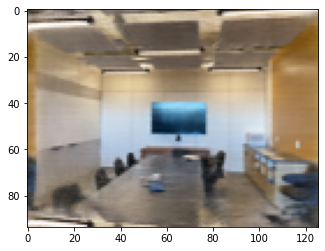

In [ ]:
# shows the first frame of the rendered video
video = jnp.empty((int(height), int(width), 3))
for j in range(int(height)):
  batch_directions = rendered_video_directions[0,:,j,:]
  batch_origins = rendered_video_origins[0]
  batch_origins = jnp.broadcast_to(batch_origins, batch_directions.shape)
  batch_origins, batch_directions = ndc_rays(height, width, focal_length, 1, batch_origins, batch_directions)
  dummy_real_pixels = jnp.zeros((int(width), 3))

  model_output, state = NeRF.apply(params, state, None, batch_origins, batch_directions, near, far, dummy_real_pixels)
  video = video.at[j].set(model_output["pixels"])
plt.imshow(video)

In [ ]:
# for saving the whole rendered video
# this may take 1-2 hours on cpu
video = jnp.empty((60, int(height), int(width), 3))
for i in range(0, 60, 1):
  for j in range(int(height)):
    batch_directions = rendered_video_directions[i,:,j,:]
    batch_origins = rendered_video_origins[i]
    batch_origins = jnp.broadcast_to(batch_origins, batch_directions.shape)
    batch_origins, batch_directions = ndc_rays(height, width, focal_length, 1, batch_origins, batch_directions)
    dummy_real_pixels = jnp.zeros((int(width), 3))

    model_output, state = NeRF.apply(params, state, None, batch_origins, batch_directions, near, far, dummy_real_pixels)
    video = video.at[i,j].set(model_output["pixels"])
imageio.mimwrite(os.path.join(datadir, "videos", 'video.mp4'),
                        video, fps=30, quality=8)

###Plot Losses

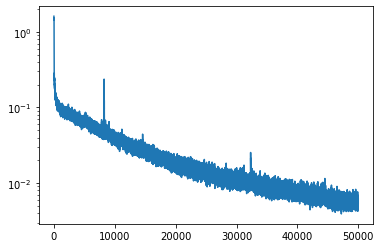

In [ ]:
# Note: if the training was interrupted and restarted, some sudden bumps in the losses may appear
path = datadir + "/losses"
dirs = os.listdir(path)

def get_losses():
  losses = jnp.array([])
  for item in dirs:
    losses = jnp.append(losses, jnp.load(os.path.join(path, item)))
  return losses

losses = get_losses()

plt.yscale("log")
plt.plot(losses)
plt.show()